# Titanic - Machine Learning from Disaster

## Introduction

In this notebook, we will create a tournament for traditional machine learning models, some of the most common classifiers to solve the Titanic problem!  
We will focus on getting the best model in solving this problem. 

The project scope will fit the following classifiers to the Titanic dataset:
- Logistic regression
- K-nearest neighbours (KNN)
- Support vector machines (SVM)
- Random Forests
- AdaBoost
- XGBoost

We will then proceed on to train a **Keras Sequential Neural Network** and compare the performance between the Machine Learning Architectures.


Lets import everything we will require. 

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# import data
test_df = pd.read_csv("data/test.csv")
train_df = pd.read_csv("data/train.csv")

# rename columns to all lower case separated by underscore
train_df.columns = train_df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()
test_df.columns = test_df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()

train_df.head()

,passenger_id,survived,pclass,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Exploratory Data Analysis

1. First thing we check for is any missing values in both training and testing sets, and impute them.

In [4]:
# identify null columns
def identify_null_columns(df, df_name):     
    null_df = pd.DataFrame(df.isnull().sum(), columns=[f'{df_name} Null Count'])
    return display(null_df[null_df[f'{df_name} Null Count'] > 0])

print(f"Finding Missing values for Train{(train_df.shape)} and Test Data{test_df.shape}:")

identify_null_columns(train_df, 'train data')
identify_null_columns(test_df, 'test data')

null_train = train_df.columns[train_df.isnull().any()].tolist()
null_test = test_df.columns[test_df.isnull().any()].tolist()

print(f"columns with missing values for train set:\n{null_train}\n")
print(f"columns with missing values for test set:\n{null_test}\n")

# train_df['embarked'].nunique() # Embarked has 3 unique columns
# train_df['cabin'].nunique() # Train Cabin has 147 unique values
# train_df['cabin'].nunique() # Train Cabin has 147 unique values
# test_df['cabin'].nunique() # Test Cabin has 76 unique values


Finding Missing values for Train(891, 12) and Test Data(418, 11):


,train data Null Count
age,177
cabin,687
embarked,2


,test data Null Count
age,86
fare,1
cabin,327


columns with missing values for train set:
['age', 'cabin', 'embarked']

columns with missing values for test set:
['age', 'fare', 'cabin']



`cabin` column has many missing values in training and testing data. In this project scope, I assume raw cabin numbers are too specific for a model to learn from. Instead, we extract the first letter (the Deck), and impute the missing values with `U` for 'Unknown'.

The `cabin` column has rows where passangers booked more than one room. Example, `C23 C25 C27`. This indicates a passenger booked multiple rooms. We create a `cabin_count` column.

In [5]:
# make a copy of train and test df for manipulation
train_data = train_df.copy()
test_data = test_df.copy()

# impute cabin missing values as Unknown
train_data['cabin'] = train_data['cabin'].fillna('Unknown')
test_data['cabin'] = test_data['cabin'].fillna('Unknown')

# Extract Deck
train_data['deck'] = train_data['cabin'].str.slice(0,1)
test_data['deck'] = test_data['cabin'].str.slice(0,1)

# view result
print(f"The deck column has these unique values/classes formed from cabin:\n{train_data['deck'].unique()}")

# Count how many cabins are listed (1 if single, 3 for 'C23 C25 C27')
train_data['cabin_count'] = train_data['cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
test_data['cabin_count'] = test_data['cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))



The deck column has these unique values/classes formed from cabin:
['U' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


Embarked column on training data has 2 missing values. The two rows are almost identical with only differences in `passenger_id`, `name`, and `age`.

In [6]:
train_data[train_data['embarked'].isnull()]

,passenger_id,survived,pclass,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked,deck,cabin_count
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,B,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,B,1


Let us visualize the value counts for each embarking port.

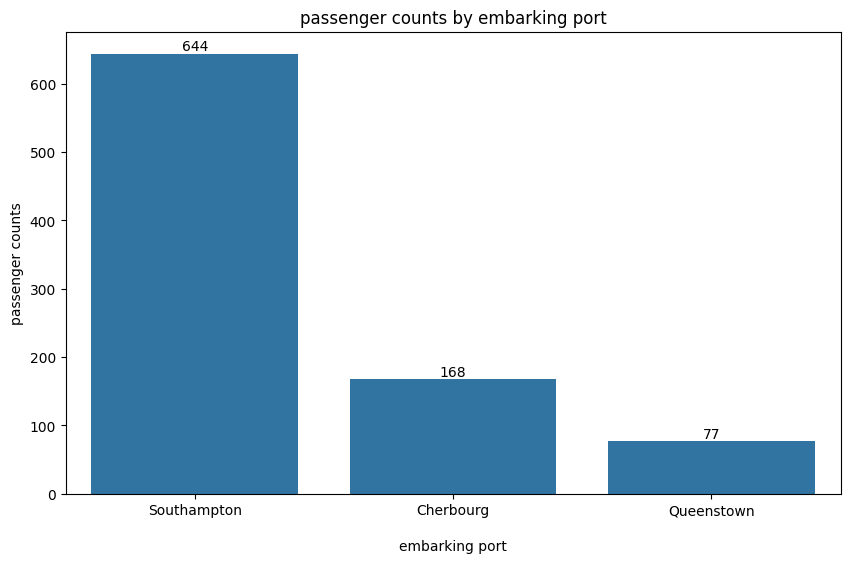

embarked
S    0.724409
C    0.188976
Q    0.086614
Name: proportion, dtype: float64

In [7]:
# the embarking points in our data are not descriptive/intuitive. 
# a dictionary to map abbreviations to full names
port_names = {
'C': 'Cherbourg',
'Q': 'Queenstown',
'S': 'Southampton'
}

# Apply the mapping to the 'embarked' column before plotting
train_data['embarking_port'] = train_data['embarked'].map(port_names)

plt.figure(figsize=(10, 6))

# Plot
ax = sns.countplot(data=train_data, x='embarking_port')

plt.title('passenger counts by embarking port')
plt.ylabel('passenger counts')
plt.xlabel('\nembarking port')
# add labels
for container in ax.containers:
    ax.bar_label(container) #

plt.show()

# proportions
train_data['embarked'].value_counts(normalize=True)


72% of all passengers in the training set embarked at southampton. There is a high probability that the 2 missing embarking ports are also from Southampton. We impute our 2 missing `embarked` values with `S`, and also `embarking_point` with `Southampton`.  

In [8]:
# finally impute missing embarking point values
train_data['embarked'] = train_data['embarked'].fillna('S')
train_data['embarking_port'] = train_data['embarking_port'].fillna('Southampton')
# train_data

# update test data with new embarking_port column by mapping names
test_data['embarking_port'] = test_data['embarked'].map(port_names)

There is a significant number of missing age values in both the training and testing data. I implemented a hierarchical funnel imputation approach:
- **Multi-Level Grouping**: I grouped passengers by `salutation` (extracted from Name), `pclass`, `sex`, and `parch` (family status). These features serve as a highly accurate proxy for age—for instance, distinguishing a young "Miss" traveling with parents from an adult "Miss" traveling alone.
- **Iterative Fallback (Funnel)**: The imputation runs through four levels of specificity, starting with all four features and gradually broadening the criteria. This ensures that even if a passenger belongs to a rare demographic group, they are still assigned a statistically relevant age based on their remaining characteristics.
- I utilized the transform method with the median rather than the mean. The median provides the most typical age for each demographic while remaining robust against extreme outliers and skewed distributions.
- Global Safety Net: A final global median fill was applied to ensure 100% data completeness. This is a critical step to prevent model failure during training and to handle rare edge cases in the test set (such as the "Ms" salutation) that may not have a direct statistical match in the training data.
This granular approach is critical for the Titanic problem because age-based rules like "children first" were primary drivers of survival.

In [9]:
# extract salutations from name.
train_data['salutation'] = train_data['name'].str.extract(r'([A-Za-z]+)\.')
test_data['salutation'] = test_data['name'].str.extract(r'([A-Za-z]+)\.')

# List of groupings from most specific to least specific
levels = [
    ['salutation', 'pclass', 'sex', 'parch'],
    ['salutation', 'pclass', 'sex'],
    ['salutation', 'pclass'],
    ['salutation']
]

# loop on both datasets
for df in [train_data, test_data]:
    for group in levels:
        df['age'] = df['age'].fillna(df.groupby(group)['age'].transform('median'))
    
    # Final safety net for any remaining NaNs
    df['age'] = df['age'].fillna(df['age'].median())

# Verify no more age nulls
print(f"train_data age nulls: {train_data.age.isnull().sum()}, test_data age nulls: {test_data.age.isnull().sum()}")


train_data age nulls: 0, test_data age nulls: 0


To address the single missing value in the fare column in test set, I applied a targeted imputation based on the passenger's class and port of embarkation. This ensures the estimated fare remains consistent with the socio-economic and geographic context of the passenger's journey, avoiding the bias of a global average.

In [10]:
test_data['fare'] = test_data.groupby(['pclass', 'embarked'])['fare'].transform(lambda x: x.fillna(x.median())).iloc[152]

We have now filled in all missing values without loosing any data for training and testing

In [11]:
identify_null_columns(train_data, 'train_data')
identify_null_columns(test_data, 'test_data')
print(f"train_data shape: {train_data.shape}\ntest_data shape: {test_data.shape}")

,train_data Null Count


,test_data Null Count


train_data shape: (891, 16)
test_data shape: (418, 15)


### Encoding the categorical variables

Some of the variables are redundant, and will be dropped. These were useful for engineering, but if we keep them now, I assume they will add noise or cause **leaking** during training:
- name: The full string is too unique for a model to learn from.
- ticket: High cardinality (too many unique values) and difficult for standard models to interpret without heavy NLP.
- cabin: we’ve already extracted the deck. The raw cabin numbers are mostly missing.
- embarking_port: This is just a longer version of the embarked code (e.g., "Southampton" vs "S"). 

- **cabin_count: we retain it since it suggests a survival correlation for people with multiple cabins**
- **passenger_id: A random unique number. It has zero correlation with survival. We set this to index**

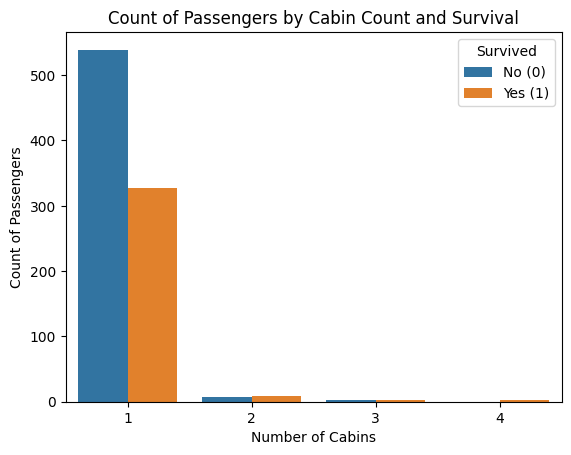

,Did Not Survive (0),Survived (1),Total Passengers
cabin_count,,,
1,539,328,867
2,7,9,16
3,3,3,6
4,0,2,2


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the count to the y-axis by using countplot
# We put cabin_count on x to see the distribution
# plt.figure(figsize=(8, 5))
sns.countplot(x='cabin_count', hue='survived', data=train_data)

plt.title('Count of Passengers by Cabin Count and Survival')
plt.xlabel('Number of Cabins')
plt.ylabel('Count of Passengers')
plt.legend(title='Survived', labels=['No (0)', 'Yes (1)'])
plt.show()


# Create a summary DataFrame using pivot_table
summary_df = train_data.pivot_table(
    index='cabin_count', 
    columns='survived', 
    values='passenger_id',  # Use a non-null column for counting
    aggfunc='count',
    fill_value=0 # Fill missing counts with zero
)

# Rename the columns for clarity (e.g., No and Yes)
summary_df.columns = ['Did Not Survive (0)', 'Survived (1)']
# Add a total column for context
summary_df['Total Passengers'] = summary_df.sum(axis=1)
display(summary_df)


In [13]:
# set index
train_data = train_data.set_index('passenger_id')
test_data = test_data.set_index('passenger_id')

In [14]:
columns_to_drop = [
    'name',
    'ticket',
    'cabin',
    'embarking_port'
]

# drop columns
train_data = train_data.drop(columns=columns_to_drop, axis=1, errors='ignore')
test_data = test_data.drop(columns=columns_to_drop, axis=1, errors='ignore')

# separate predictors from labels
y_train = train_data['survived']
X_train = train_data.drop('survived', axis=1)
X_test = test_data.copy()

X_train.shape, X_test.shape


((891, 10), (418, 10))

The last step before training is encoding. I applied One-Hot Encoding to categorical features like sex and salutation to convert them into a model-readable binary format without implying a false mathematical order. Simultaneously, I utilized Standardization (StandardScaler) on numerical features to ensure all variables have a mean of zero and unit variance.

In [15]:
# Define which columns get which treatment
num_features = ['age', 'fare', 'sib_sp', 'parch', 'pclass']
cat_features = ['sex', 'embarked', 'salutation']

# Create the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# X contains the features, y contains the 'survived' target
X = train_data.drop('survived', axis=1)
y = train_data['survived']

# Fit on training data and transform both (prevents data leakage)
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


## Training the classifiers

We will train 8 different types of classifiers. For each type of model, we will use `GridSearchCV` to find the optimal hyperparameters for our Titanic dataset problem. After we find the best parameters for each model, we then hold our tournament, and get the best classifierds, out of the best. This is an iterative process to get the best predictions.

### Hyperparameter tuning

I have commented out the code used in the grid search for each of the models, for efficiency if you run all cells. Some of these cells that are commented out took long to complete.

In [16]:
# Convert sparse matrix to a dense NumPy array
X_train_dense = X_train_scaled.toarray()
X_test_dense = X_test_scaled.toarray()

In [ ]:
# # LogisticRegression
# # hyperparameters to test
# param_grid = {
#     'C': np.logspace(-3, 3, 7),
#     'l1_ratio': [0, 0.5, 1], 
#     }

# # Setup GridSearchCV
# logreg = LogisticRegression(solver='saga', max_iter=5000)
# logclf = GridSearchCV(logreg, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# # Create interactions (degree=2) like age*fare, age*pclass, etc.
# poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# X_train_poly = poly.fit_transform(X_train_scaled)
# X_test_poly = poly.transform(X_test_scaled)

# # Fit
# logclf.fit(X_train_poly, y_train)

# # View results
# print("Best Logistic Regression Params:", logclf.best_params_)
# print("Best Logistic Regression Score:", logclf.best_score_)

# # Best Logistic Regression Params: {'C': np.float64(0.01), 'l1_ratio': 0}
# # Best Logistic Regression Score: 0.8316729088639201

In [ ]:
# from sklearn.feature_selection import SelectKBest, f_classif

# # Select the top 7 features based on previous best results
# selector = SelectKBest(score_func=f_classif, k=7)
# X_train_selected = selector.fit_transform(X_train_dense, y_train)
# X_test_selected = selector.transform(X_test_dense)


# # Initialize model
# knn = KNeighborsClassifier()

# knn_param_grid = {
#     # Testing every integer around 17 to find the absolute peak
#     'n_neighbors': [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
    
#     # Keeping both, though 'distance' is currently winning
#     'weights': ['uniform', 'distance'],
    
#     # p=1 (Manhattan) is king, but we include 2 (Euclidean) for safety
#     'p': [1, 2], 
    
#     # the result showed 1 was best, so we stay very low
#     'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    
#     # Adding 'metric' can sometimes unlock different internal calculations
#     'metric': ['minkowski', 'manhattan']
# }
# # Setup and fit GridSearchCV
# knn_grid = GridSearchCV(
#     estimator=knn, 
#     param_grid=knn_param_grid, 
#     cv=10, 
#     scoring='accuracy', 
#     n_jobs=-1
# )

# knn_grid.fit(X_train_selected, y_train)

# print(f"Best KNN Score: {knn_grid.best_score_}")
# print(f"Best KNN Params: {knn_grid.best_params_}")

# # Best KNN Score: 0.8249438202247191
# # Best KNN Params: {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}

In [ ]:
# # SVC

# # Initialize the Support Vector Classifier
# svc = SVC()

# # Define the grid focusing on RBF and C/gamma relationships
# param_grid_svc = {
#     # Test broad orders of magnitude for C
#     'C': [0.1, 1, 10, 100, 1000],
    
#     # 'scale' is the modern 2026 default, but we test specific values too
#     'gamma': [1, 0.1, 0.01, 0.001, 'scale'],
    
#     # RBF is typically best, but linear is a good baseline
#     'kernel': ['rbf', 'linear']
# }

# # Setup GridSearchCV with 10-fold CV for stability
# svc_grid = GridSearchCV(
#     estimator=svc, 
#     param_grid=param_grid_svc, 
#     cv=10, 
#     scoring='accuracy', 
#     n_jobs=-1
# )

# # Fit on dense scaled data
# svc_grid.fit(X_train_dense, y_train)

# print(f"Best SVM Score: {svc_grid.best_score_}")
# print(f"Best SVM Params: {svc_grid.best_params_}")

# # Best SVM Score: 0.8350187265917602
# # Best SVM Params: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Best SVM Score: 0.8350187265917602
Best SVM Params: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
# # RainForest

# # Initialize the model
# rf = RandomForestClassifier(random_state=42)

# # Define the grid
# param_grid_rf = {
#     # Number of trees 
#     'n_estimators': [100, 200, 500],
    
#     # Depth of each tree 
#     'max_depth': [None, 5, 8, 10, 12],
    
#     # Minimum samples required to split a node
#     'min_samples_split': [2, 5, 10],
    
#     # Minimum samples required at a leaf node
#     'min_samples_leaf': [1, 2, 4],
    
#     # Number of features to consider at every split
#     'max_features': ['sqrt', 'log2']
# }

# # Setup GridSearchCV
# rf_grid = GridSearchCV(
#     estimator=rf, 
#     param_grid=param_grid_rf, 
#     cv=10, 
#     scoring='accuracy', 
#     n_jobs=-1,
#     verbose=1
# )

# # Fit on training data
# rf_grid.fit(X_train_dense, y_train)

# print(f"Best RF Score: {rf_grid.best_score_}")
# print(f"Best RF Params: {rf_grid.best_params_}")

# # Best RF Score: 0.8395630461922596
# # Best RF Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


Fitting 10 folds for each of 270 candidates, totalling 2700 fits


d:\Programs\anaconda3\envs\ALX_main\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF Score: 0.8395630461922596
Best RF Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
# # adaboost

# # Initialize the base estimator 
# base_est = DecisionTreeClassifier(max_depth=1)

# ada = AdaBoostClassifier(estimator=base_est, random_state=42)

# # Define a grid
# param_grid_ada = {
#     'n_estimators': [50, 100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],    
# }

# # Setup GridSearchCV
# # We use n_jobs=-1 but fewer total combinations (20 candidates)
# ada_grid = GridSearchCV(
#     ada, 
#     param_grid_ada, 
#     cv=10, 
#     scoring='accuracy', 
#     n_jobs=-1
# )

# # Fit 
# ada_grid.fit(X_train_dense, y_train)

# print(f"Best adaboost Score: {ada_grid.best_score_}")
# print(f"Best adaboost Params: {ada_grid.best_params_}")

# # Best adaboost Score: 0.8238077403245943
# # Best adaboost Params: {'learning_rate': 1.0, 'n_estimators': 200}

Best adaboost Score: 0.8238077403245943
Best adaboost Params: {'learning_rate': 1.0, 'n_estimators': 200}


In [ ]:
# # XGBClassifier

# # Initialize XGBoost
# # Use 'binary:logistic' for Titanic survival
# xgb = XGBClassifier(
#     n_estimators=200, 
#     random_state=42, 
#     use_label_encoder=False, 
#     eval_metric='logloss'
# )

# # Optimized Grid 
# param_grid_xgb = {
#     # How fast the model learns 
#     'learning_rate': [0.01, 0.05, 0.1],
    
#     # Depth of trees 
#     'max_depth': [3, 5, 7],
    
#     # Percentage of features to use per tree 
#     'colsample_bytree': [0.7, 0.8, 1.0],
    
#     # Minimum loss reduction required to make a further partition
#     'gamma': [0, 0.1, 0.2]
# }

# # Setup GridSearchCV
# # Using n_jobs=2 to keep laptop responsive
# xgb_grid = GridSearchCV(
#     estimator=xgb, 
#     param_grid=param_grid_xgb, 
#     cv=10, 
#     scoring='accuracy', 
#     n_jobs=2,
#     verbose=1
# )

# # Fit on dense scaled data
# xgb_grid.fit(X_train_dense, y_train)

# print(f"Best XGB Score: {xgb_grid.best_score_}")
# print(f"Best XGB Params: {xgb_grid.best_params_}")

# # Best XGB Score: 0.8451560549313358
# # Best XGB Params: {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7}

Fitting 10 folds for each of 81 candidates, totalling 810 fits


d:\Programs\anaconda3\envs\ALX_main\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:29:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Score: 0.8451560549313358
Best XGB Params: {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7}


### Model Tournament

We now use the best params for each model in the tournament, then use the voting classifier for final decision.

In [ ]:
# Define the names of the classifiers
names = ['Logistic Regression', 'Nearest Neighbors', 'SVC', 'Random Forest', 'AdaBoost', 'XGBoost']

# Manually define the classifiers based on best params discovered for each
classifiers = [
    LogisticRegression(C=0.01, l1_ratio=0), 
    KNeighborsClassifier(leaf_size=1, metric='minkowski', n_neighbors=17, p=1, weights='distance'), 
    SVC(C=1000, gamma=0.001, kernel='rbf'), 
    RandomForestClassifier(max_depth=None, max_features='sqrt',min_samples_leaf=2, min_samples_split=5, n_estimators=100), 
    AdaBoostClassifier(learning_rate=1.0, n_estimators=200),
    XGBClassifier(colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=7)
]


In [37]:
results = {}

# Loop through each classifier
for name, clf in zip(names, classifiers):
    # Perform 5-fold Cross Validation
    # This splits the data 5 times and calculates the average accuracy
    scores = cross_val_score(clf, X_train_dense, y_train, cv=5)
    results[name] = scores.mean()
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Find the winner
winner = max(results, key=results.get)
print(f"\nThe Tournament Winner based on cross_val_score is: {winner}")


Logistic Regression: 0.7958 (+/- 0.0267)
Nearest Neighbors: 0.8058 (+/- 0.0356)
SVC: 0.8305 (+/- 0.0278)
Random Forest: 0.8249 (+/- 0.0228)
AdaBoost: 0.8148 (+/- 0.0164)
XGBoost: 0.8406 (+/- 0.0257)

The Tournament Winner based on cross_val_score is: XGBoost


XGBoost stood out with a higher cross validation score. We will make predictions with each model, and submit to kaggle for assessment.

In [ ]:
predictions = {}

# Loop through each classifier
for name, clf in zip(names, classifiers):
    print(f"training {name}...")
    clf.fit(X_train_dense, y_train)
    
    # Create submission file
    submission = pd.DataFrame({
    "PassengerId": test_data.index,
    "Survived": clf.predict(X_test_dense)
    })
    
    submission.to_csv(f'individual_trad_model_submissions/{name}_submission.csv', index=False)
    
    print(f"...saved {name} predictions\n")


training Logistic Regression...
...saved Logistic Regression predictions

training Nearest Neighbors...
...saved Nearest Neighbors predictions

training SVC...
...saved SVC predictions

training Random Forest...
...saved Random Forest predictions

training AdaBoost...
...saved AdaBoost predictions

training XGBoost...
...saved XGBoost predictions



Here are the kaggle scores for each model's predictions upon submission:

<img src="img/individual_models_scores.png" width="800" alt="Kaggle scores for predictions for individual tradional ML models">

We will then use the top 3 high scorers in a voting ensemble, train it, and make predictions.

In [39]:
# Use the 3 top performers from the tournament in the VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('svc', SVC(C=1000, gamma=0.001, kernel='rbf', probability=True)),
    ('ada', AdaBoostClassifier(learning_rate=1.0, n_estimators=200)),
    ('lr', LogisticRegression(C=0.01, l1_ratio=0)),
], voting='soft')

voting_clf.fit(X_train_dense, y_train)

# Predict the official test data
final_predictions = voting_clf.predict(X_test_dense)

# Create the submission file
submission = pd.DataFrame({
    "PassengerId": test_data.index,
    "Survived": final_predictions
})
submission.to_csv('vc_submission.csv', index=False)


In [ ]:
scores = cross_val_score(voting_clf, X_train_dense, y_train, cv=10)
print(f"Voting Score: {scores.mean():.4f} (+/- {scores.std():.4f})")

Voting Score: 0.8350 (+/- 0.0341)


<img src="img/vc_score.png" width="800" alt="Kaggle score for voting classifier predictions">

This marks the end of our tournament predictions, and we have attained a score of 0.77751 at Kaggle using voting ensemble. This is lower than the Logistic Regression Model predictions' score (0.79425).

We will now advance to a deep learning model, and see whether we can improve our predictions. 

# Using the Keras Sequential Model

We will implement a Neural Network using Tensorflow.

In [54]:
print(f"X_train_dense shape: {X_train_dense.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test_dense shape: {X_test_dense.shape}")

X_train_dense shape: (891, 27)
y_train shape: (891,)
X_test_dense shape: (418, 27)


Building the model:

In [58]:
# Define the Sequential model
model = Sequential([
    # Input layer matching the number of features in the X_train_dense np array
    Input(shape=(X_train_dense.shape[1],)),
    
    # Layer 1: 32 neurons with 'swish' (modern alternative to ReLU)
    Dense(32, activation='swish'),
    Dropout(0.3), # Randomly disables 30% of neurons to force "teamwork"
    
    # Layer 2: 16 neurons
    Dense(16, activation='swish'),
    Dropout(0.2),
    
    # Output: Single neuron with Sigmoid for 0-1 probability
    Dense(1, activation='sigmoid')
])

Compile with binary crossentropy for a classification task

In [59]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

We use EarlyStopping to stop training if validation accuracy plateaus

In [60]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Train the Model

In [61]:
# Train
history = model.fit(
    X_train_dense, y_train,
    epochs=100, # Large number, but early_stop will end it sooner
    batch_size=32,
    validation_split=0.2, # Uses 20% of data to check for overfitting live
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6067 - loss: 0.6691 - val_accuracy: 0.7709 - val_loss: 0.6218
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7233 - loss: 0.6064 - val_accuracy: 0.8045 - val_loss: 0.5585
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7556 - loss: 0.5674 - val_accuracy: 0.8101 - val_loss: 0.5002
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7739 - loss: 0.5169 - val_accuracy: 0.8156 - val_loss: 0.4527
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7556 - loss: 0.5050 - val_accuracy: 0.8156 - val_loss: 0.4207
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7963 - loss: 0.4758 - val_accuracy: 0.8268 - val_loss: 0.4013
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7935 - loss: 0.4633 - val_accuracy: 0.8547 - val_loss: 0.3876
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8006 - loss: 0.4663 - val_accuracy: 0.

### Predict

In [ ]:
# Get probabilities
tf_probs = model.predict(X_test_dense)

# Convert to 0 or 1 using flatten
# .astype(int) converts True/False to 1/0
tf_predictions = (tf_probs.flatten() > 0.5).astype(int)

# Create the submission file
submission = pd.DataFrame({
    "PassengerId": test_data.index,
    "Survived": tf_predictions
})

submission.to_csv('tf_submission.csv', index=False)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


<img src="img/tf_score.png" width="800" alt="Kaggle score for predictions for the Keras Sequential Neural Network">

Done! Our Neural Network scored 0.79186, lower than our MVP, the Logistic Regression model (0.79425). 

On a small, tabular dataset like the Titanic, high-complexity models tended to overfit to noise, while the linear baseline captured the patterns most effectively.

We leave at this point for now, thank you for following my work all along.